In [1]:
#Distribution elaad
#inter arrival distributions and processing time

#old code # created elaad_env

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import gamma
import numpy as np
import pickle


In [2]:
file_path1 = r"/mnt/c/Users/s139501/CSV/open_transactions.csv"
file_path2 = r"/mnt/c/Users/s139501/CSV/open_metervalues.csv"

df1 = pd.read_csv(file_path1, delimiter=';', decimal=',')
df2 = pd.read_csv(file_path2, delimiter=';', decimal=',')

# Convert the columns to datetime
df1['UTCTransactionStart'] = pd.to_datetime(df1['UTCTransactionStart'], format='%d/%m/%Y %H:%M')
df1['UTCTransactionStop'] = pd.to_datetime(df1['UTCTransactionStop'], format='%d/%m/%Y %H:%M')

# Extract the hours and days
df1['ArrivalHour'] = df1['UTCTransactionStart'].dt.hour
df1['DepartureHour'] = df1['UTCTransactionStop'].dt.hour
df1['DayOfWeek'] = df1['UTCTransactionStart'].dt.dayofweek
df1['ArrivalMinute'] = df1['UTCTransactionStart'].dt.hour * 60 + df1['UTCTransactionStart'].dt.minute

# Segregate df1 into weekdays and weekends
df_weekdays = df1[df1['DayOfWeek'].between(0, 4)]
df_weekends = df1[df1['DayOfWeek'].between(5, 6)]

# Separate arrival and departure dataframes for weekdays and weekends
arrival_weekdays = df_weekdays[['ArrivalHour']]
departure_weekdays = df_weekdays[['DepartureHour']]
arrival_weekends = df_weekends[['ArrivalHour']]
departure_weekends = df_weekends[['DepartureHour']]

# Calculate the average number of arrivals per hour for weekdays
average_hourly_arrivals_weekdays = df_weekdays.groupby('ArrivalHour').size().reset_index(name='AverageArrivals')
average_hourly_arrivals_weekdays['AverageArrivals'] /= len(df_weekdays['DayOfWeek'].unique())

# Average hourly departures for weekdays
average_hourly_departures_weekdays = df_weekdays.groupby('DepartureHour').size().reset_index(name='AverageDepartures')
average_hourly_departures_weekdays['AverageDepartures'] /= len(df_weekdays['DayOfWeek'].unique())

# Average hourly arrivals for weekends
average_hourly_arrivals_weekends = df_weekends.groupby('ArrivalHour').size().reset_index(name='AverageArrivals')
average_hourly_arrivals_weekends['AverageArrivals'] /= len(df_weekends['DayOfWeek'].unique())

# Average hourly departures for weekends
average_hourly_departures_weekends = df_weekends.groupby('DepartureHour').size().reset_index(name='AverageDepartures')
average_hourly_departures_weekends['AverageDepartures'] /= len(df_weekends['DayOfWeek'].unique())


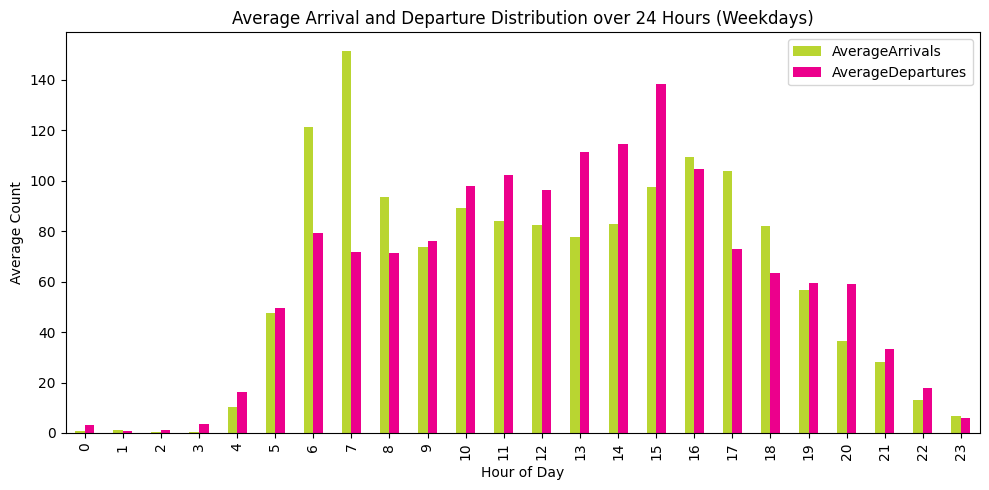

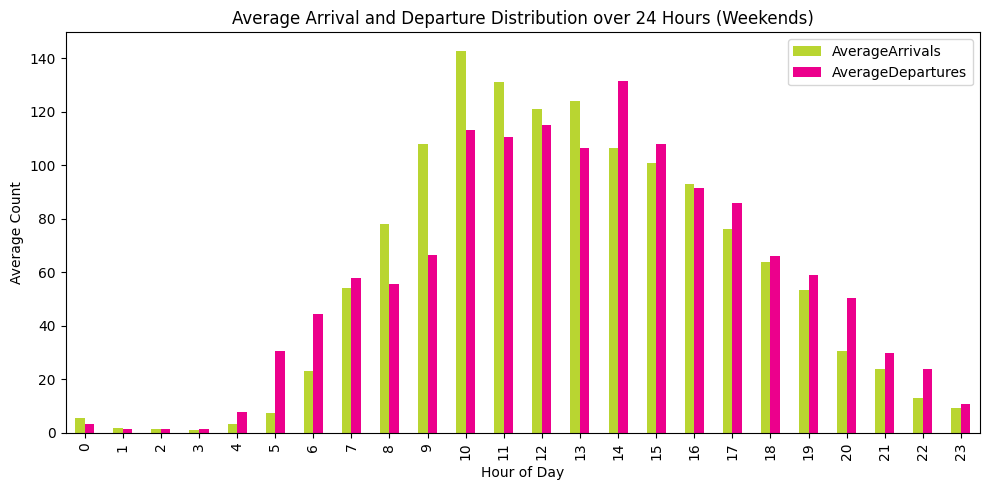

In [4]:
# Function to plot the distribution
def plot_average_distribution(arrival_df, departure_df, title_suffix, colors=['#B9D531', '#EC008C']):
    # Merge the dataframes on the hour
    combined_df = pd.merge(arrival_df, departure_df, left_on='ArrivalHour', right_on='DepartureHour', how='outer')
    combined_df = combined_df.fillna(0)  # Fill NaN values with 0
    combined_df.plot(x='ArrivalHour', y=['AverageArrivals', 'AverageDepartures'], kind='bar', figsize=(10, 5), color=colors)
    plt.title(f'Average Arrival and Departure Distribution over 24 Hours ({title_suffix})')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.xticks(range(24))
    plt.tight_layout()

# Plotting for weekdays and weekends
plot_average_distribution(average_hourly_arrivals_weekdays, average_hourly_departures_weekdays, 'Weekdays', colors=['#B9D531', '#EC008C'])
plot_average_distribution(average_hourly_arrivals_weekends, average_hourly_departures_weekends, 'Weekends', colors=['#B9D531', '#EC008C'])

plt.show()

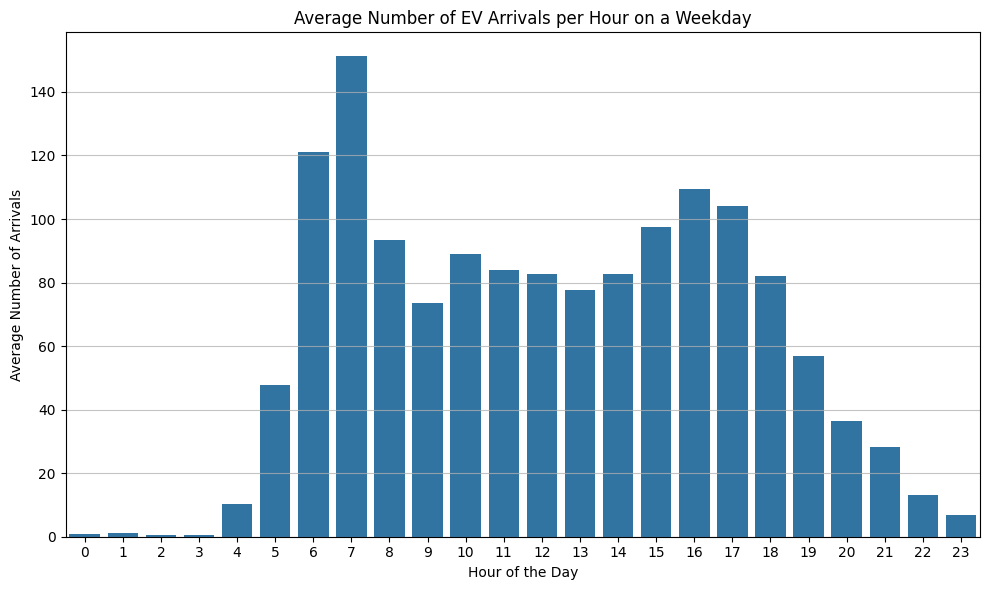

In [5]:
# Plotting the average number of arrivals per hour for weekdays
plt.figure(figsize=(10, 6))
sns.barplot(data=average_hourly_arrivals_weekdays, x='ArrivalHour', y='AverageArrivals')
plt.title('Average Number of EV Arrivals per Hour on a Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Arrivals')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

1296       0.0
3562       0.0
3419       0.0
3374       0.0
9418       0.0
         ...  
8651     910.0
1484    1039.0
1648    2169.0
4399    8126.0
9458       NaN
Name: TimeDiff, Length: 10000, dtype: float64


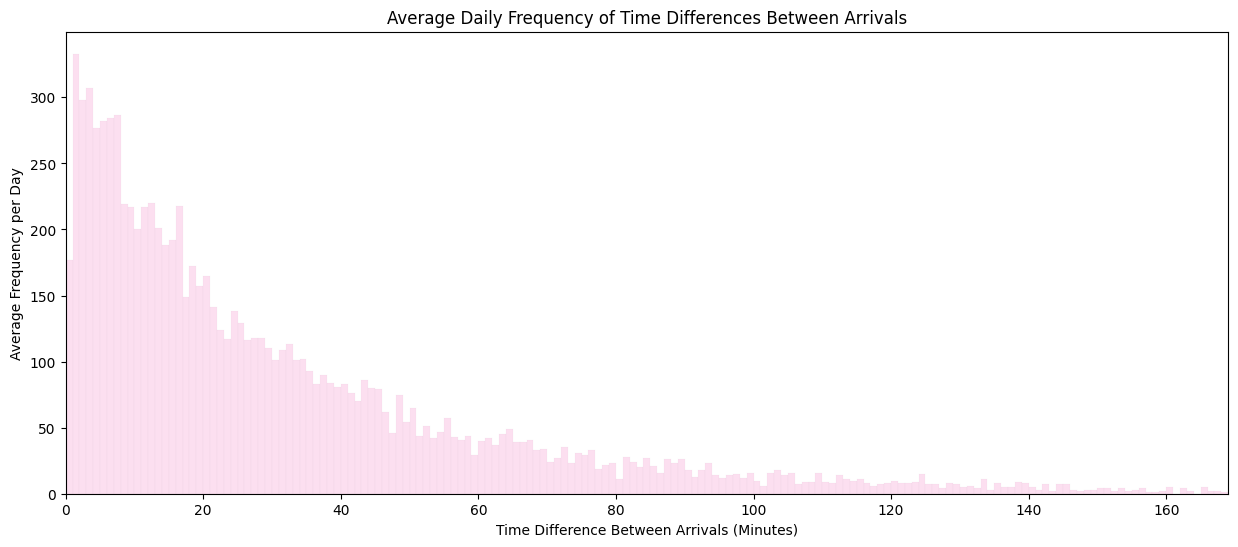

In [6]:
##PER MINUTE A##
# Function to distributions
def calculate_distribution_params(df):
    df_sorted = df.sort_values(by='UTCTransactionStart')
    df_sorted['TimeDiff'] = df_sorted['UTCTransactionStart'].diff().dt.total_seconds() / 60
    df_sorted = df_sorted.dropna(subset=['TimeDiff'])
    df_sorted['TimeDiff'] = np.where(df_sorted['TimeDiff'] <= 0, 0.001, df_sorted['TimeDiff'])
    params_gamma = stats.gamma.fit(df_sorted['TimeDiff'], floc=0)
    params_expon = stats.expon.fit(df_sorted['TimeDiff'], floc=0)
    return params_gamma, params_expon, df_sorted

params_gamma, params_expon, df1_sorted = calculate_distribution_params(df1)

#save params_gamma LOOK! I AM A PICKLE
with open('params_gamma.pkl', 'wb') as f:
    pickle.dump(params_gamma, f)

# Generate points on the x axis suitable for the range of your data
x_gamma = np.linspace(start=0, stop=df1_sorted['TimeDiff'].max(), num=10000)
x_expon = np.linspace(start=0, stop=df1_sorted['TimeDiff'].max(), num=10000)

# Calculate the number of unique days in the dataset
num_days = df1_sorted['UTCTransactionStart'].dt.date.nunique()

# Calculate the frequency of transaction arrivals per day
time_diff_per_day = df1_sorted['TimeDiff'].value_counts().sort_index() / num_days

#plot
plt.figure(figsize=(15, 6))
bin_size = 1  # The bin size can be adjusted to increase of decrease granularity
bins = int((df1_sorted['TimeDiff'].max() - df1_sorted['TimeDiff'].min()) / bin_size)
sns.histplot(df1_sorted['TimeDiff'], bins=bins, color='#FBD5EC')
plt.xlabel('Time Difference Between Arrivals (Minutes)')
plt.ylabel('Average Frequency per Day')
plt.title('Average Daily Frequency of Time Differences Between Arrivals')
plt.xlim(0, df1_sorted['TimeDiff'].quantile(0.95))  # Limit x-axis to exclude rare extreme values if necessary
plt.show()

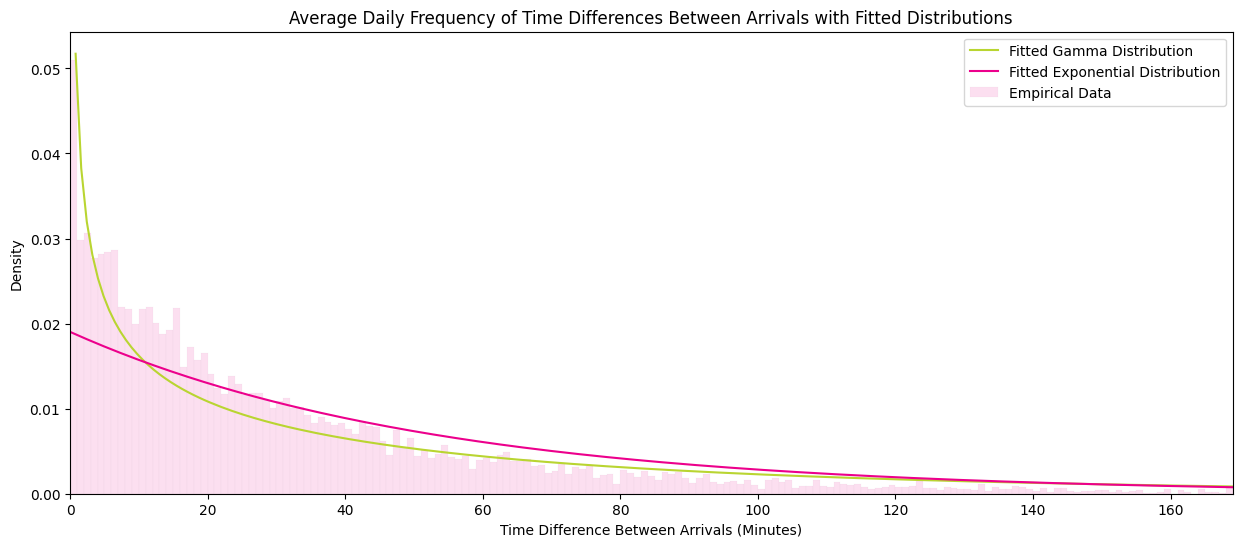

In [7]:
##PER MINUTE B: GAMMA##
# Ensure all time differences are positive (gamma distribution cannot have zero or negative values)
# Replace TimeDiff values of 0 or smaller with a small number (e.g., 0.001 seconds)
df1_sorted['TimeDiff'] = np.where(df1_sorted['TimeDiff'] <= 0, 0.001, df1_sorted['TimeDiff'])
#df1_sorted = df1_sorted[df1_sorted['TimeDiff'] > 0] #not good, since you will not take the arrivals on the same time with you

# Fit the empirical data to a gamma and an exponential distribution, fixing the location at 0
params_gamma = stats.gamma.fit(df1_sorted['TimeDiff'], floc=0)
params_expon = stats.expon.fit(df1_sorted['TimeDiff'], floc=0)

# Generate points on the x axis suitable for the range of your data
x_gamma = np.linspace(start=0, stop=df1_sorted['TimeDiff'].max(), num=10000)
x_expon = np.linspace(start=0, stop=df1_sorted['TimeDiff'].max(), num=10000)


# Plot the histogram of the empirical data
plt.figure(figsize=(15, 6))
sns.histplot(df1_sorted['TimeDiff'], bins=bins, kde=False, stat='density', label='Empirical Data', color='#FBD5EC')

# Plot the PDF of the fitted gamma distribution
pdf_gamma = stats.gamma.pdf(x_gamma, *params_gamma)
plt.plot(x_gamma, pdf_gamma, label='Fitted Gamma Distribution', color='#B9D531')

# Plot the PDF of the fitted exponential distribution
pdf_expon = stats.expon.pdf(x_expon, *params_expon)
plt.plot(x_expon, pdf_expon, label='Fitted Exponential Distribution', color='#EC008C')


# Finalize the plot (same as before)
plt.xlabel('Time Difference Between Arrivals (Minutes)')
plt.ylabel('Density')
plt.title('Average Daily Frequency of Time Differences Between Arrivals with Fitted Distributions')
plt.xlim(0, df1_sorted['TimeDiff'].quantile(0.95))
plt.legend()
plt.show()

In [ ]:
#ASSESSING THE FIT##
# Kolmogorov-Smirnov Test for Gamma Distribution
ks_statistic_gamma, ks_pvalue_gamma = stats.kstest(df1_sorted['TimeDiff'], 'gamma', args=params_gamma)
print(f"Gamma Distribution - KS Statistic: {ks_statistic_gamma}, P-Value: {ks_pvalue_gamma}")

# Kolmogorov-Smirnov Test for Exponential Distribution
ks_statistic_expon, ks_pvalue_expon = stats.kstest(df1_sorted['TimeDiff'], 'expon', args=params_expon)
print(f"Exponential Distribution - KS Statistic: {ks_statistic_expon}, P-Value: {ks_pvalue_expon}")

# Calculate AIC and BIC for Gamma Distribution
gamma_loglikelihood = np.sum(stats.gamma.logpdf(df1_sorted['TimeDiff'], *params_gamma))
gamma_aic = 2 * len(params_gamma) - 2 * gamma_loglikelihood
gamma_bic = len(params_gamma) * np.log(len(df1_sorted['TimeDiff'])) - 2 * gamma_loglikelihood

# Calculate AIC and BIC for Exponential Distribution
expon_loglikelihood = np.sum(stats.expon.logpdf(df1_sorted['TimeDiff'], *params_expon))
expon_aic = 2 * len(params_expon) - 2 * expon_loglikelihood
expon_bic = len(params_expon) * np.log(len(df1_sorted['TimeDiff'])) - 2 * expon_loglikelihood

print(f"Gamma Distribution - AIC: {gamma_aic}, BIC: {gamma_bic}")
print(f"Exponential Distribution - AIC: {expon_aic}, BIC: {expon_bic}")


In [ ]:
##NORMAL AND EXPONENTIAL DISTRIBUTION##
# Fit the empirical data to theoretical distributions
params_norm = stats.norm.fit(df1_sorted['TimeDiff'])
params_expon = stats.expon.fit(df1_sorted['TimeDiff'])

# Plot the histogram of the empirical data
plt.figure(figsize=(15, 6))
sns.histplot(df1_sorted['TimeDiff'], bins=bins, kde=False, stat='density', label='Empirical Data')

# Generate points on the x axis:
x = np.linspace(0, df1_sorted['TimeDiff'].quantile(0.95), 1000)

# Plot the PDF of the fitted normal distribution
pdf_norm = stats.norm.pdf(x, *params_norm)
plt.plot(x, pdf_norm, label='Fitted Normal Distribution', color='red')

# Plot the PDF of the fitted exponential distribution
pdf_expon = stats.expon.pdf(x, *params_expon)
plt.plot(x, pdf_expon, label='Fitted Exponential Distribution', color='green')

# Finalize the plot
plt.xlabel('Time Difference Between Transactions (Minutes)')
plt.ylabel('Density')
plt.title('Average Daily Frequency of Time Differences Between Transactions')
plt.xlim(0, df1_sorted['TimeDiff'].quantile(0.95))  # Limit x-axis to exclude rare extreme values if necessary
plt.legend()
plt.show()

In [ ]:
##PER SECOND##
# Sort data based on UTCTransactionStart
df1_sorted = df1.sort_values(by='UTCTransactionStart')

# Calculate time differences between consecutive transactions in seconds
df1_sorted['TimeDiff'] = df1_sorted['UTCTransactionStart'].diff().dt.total_seconds()

# Replace TimeDiff values of 0 or smaller with a small number (e.g., 0.001 seconds)
df1_sorted['TimeDiff'] = np.where(df1_sorted['TimeDiff'] <= 0, 0.001, df1_sorted['TimeDiff'])

# Drop the first row as it will have a NaN value for TimeDiff
df1_sorted = df1_sorted.dropna(subset=['TimeDiff'])

# Calculate the number of unique days in the dataset
num_days = df1_sorted['UTCTransactionStart'].dt.date.nunique()

# Calculate the frequency of transaction arrivals per day
time_diff_per_day = df1_sorted['TimeDiff'].value_counts().sort_index() / num_days

# Fit the gamma distribution to the 'TimeDiff' data, fixing the location at 0
params = stats.gamma.fit(df1_sorted['TimeDiff'], floc=0)

# Generate a range of values for which we will plot the gamma distribution
x = np.linspace(0, df1_sorted['TimeDiff'].quantile(0.95), 10000)

# Calculate the PDF of the fitted gamma distribution
pdf_fitted = stats.gamma.pdf(x, *params)

# Plot histogram and fitted distribution
plt.figure(figsize=(15, 6))
bin_size = 10
bins = int((df1_sorted['TimeDiff'].max() - df1_sorted['TimeDiff'].min()) / bin_size)
sns.histplot(df1_sorted['TimeDiff'], bins=bins, kde=False, stat='density')
plt.plot(x, pdf_fitted, label='Fitted Gamma Distribution')
plt.xlabel('Time Difference Between Transactions (Seconds)')
plt.ylabel('Normalized Frequency')
plt.title('Average Daily Frequency of Time Differences Between Transactions')
plt.xlim(0, df1_sorted['TimeDiff'].quantile(0.95))
plt.legend()
plt.show()

